# Automatic Apparent Age Estimation - Bias Reduction with custom methods




In [1]:
import pathlib
import pickle
import zipfile

import h5py
import matplotlib.pyplot as plt
import numpy as np
from sklearn.utils.class_weight import compute_class_weight
import tensorflow as tf
from tensorflow.keras.applications.resnet50 import preprocess_input
from tensorflow.keras.callbacks import (
    EarlyStopping, ModelCheckpoint, ReduceLROnPlateau)
from tensorflow.keras.layers import (
    BatchNormalization, Dense, Dropout, Flatten)
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.optimizers import Adam, RMSprop
# from tensorflow.keras.applications.vgg16 import VGG16

## Helper functions

In [2]:
# Dataset load and preprocess.
def load_data(stage: str):
    return (
        np.load(f'./data/data_{stage}.npy'),
        np.load(f'./data/labels_{stage}.npy'),
        np.load(f'./data/meta_data_{stage}.npy'),
    )

def preprocess_X(X) -> None:
    """Preprocess samples so they can be used as
     ResNET50 inputs."""
    for i in range(0, X.shape[0]):
        x = X[i,:,:,:]
        x = np.expand_dims(x, axis=0)
        X[i,] = preprocess_input(x)

In [3]:
# Training and model evalueation.
def plot_train_history(train_history):
    """Plot learnign curves from the training history."""
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
    fig.suptitle('Training history (stage 1)', fontsize=14, fontweight='bold')

    ax1.plot(train_history['loss'])
    ax1.plot(train_history['val_loss'])
    ax1.set(xlabel='epoch', ylabel='LOSS')
    ax1.legend(['train', 'valid'], loc='upper right')

    ax2.plot(train_history['mae'])
    ax2.plot(train_history['val_mae'])
    ax2.set(xlabel='epoch', ylabel='MAE')
    ax2.legend(['train', 'valid'], loc='upper right')
    plt.show()

In [27]:
def evaluate_model(model: Model):
    predictions = model.predict(X_test, batch_size=32, verbose=1)

    # evaluating on test data
    predictions_f = predictions*100
    error = []
    for i in range(len(Y_test)):
        error.append(
            abs(np.subtract(predictions_f[i][0], Y_test[i])),
        )
    print(f'MAE = {np.mean(error):.8f}')
    return predictions_f

# Downloading and decompressing the Appa-Real Age Dataset [(source)](http://chalearnlap.cvc.uab.es/challenge/13/track/13/description/)


In [5]:
# from google.colab import drive
# drive.mount('/content/gdrive')
root_dir = pathlib.Path('.')

Mounted at /content/gdrive


In [6]:
if not pathlib.Path('app_data.zip').exists():
    !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip

with zipfile.ZipFile('app_data.zip','r') as zip_file:
    zip_file.extractall()
    print('Data decompressed successfully')

# !rm app_data.zip

--2022-08-24 20:43:14--  https://data.chalearnlap.cvc.uab.cat/Colab_2021/app_data.zip
Resolving data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)... 158.109.8.102
Connecting to data.chalearnlap.cvc.uab.cat (data.chalearnlap.cvc.uab.cat)|158.109.8.102|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 799021037 (762M) [application/zip]
Saving to: ‘app_data.zip’

app_data.zip        100%[===================>] 762.00M  10.5MB/s    in 86s     

2022-08-24 20:44:41 (8.87 MB/s) - ‘app_data.zip’ saved [799021037/799021037]

Data decompressed successfully


# Loading the dataset.

In [7]:
# loading the train data
X_train, Y_train, M_train = load_data('train')
# loading the validation data
X_valid, Y_valid, M_valid  = load_data('valid')
# loading the test data
X_test, Y_test, M_test = load_data('test')

# train labels are real numbers, ranging from ~0.9 to ~89 (years old);
# we will re-scale the labels to [0,1] by using a normalization factor of 100,
# assuming there is no sample with age > 100.
Y_train, Y_valid = Y_train/100, Y_valid/100

# Transform the dataset so it works with the ResNet.
preprocess_X(X_train)
preprocess_X(X_valid)
preprocess_X(X_test)

print(f"Train set ::: X : {X_train.shape}, "
      f"Y : {Y_train.shape}, M : {M_train.shape}")
print(f"Valid set ::: X : {X_valid.shape}, "
      f"Y : {Y_valid.shape}, M : {M_valid.shape}")
print(f"Test set ::: X : {X_test.shape}, "
      f"Y : {Y_test.shape}, M : {M_test.shape}")

Train set ::: X : (4065, 224, 224, 3), Y : (4065,), M : (4065, 3)
Valid set ::: X : (1482, 224, 224, 3), Y : (1482,), M : (1482, 3)
Test set ::: X : (1978, 224, 224, 3), Y : (1978,), M : (1978, 3)


---
# Dataset visualizations

### Visualizing the age distribution of Train data

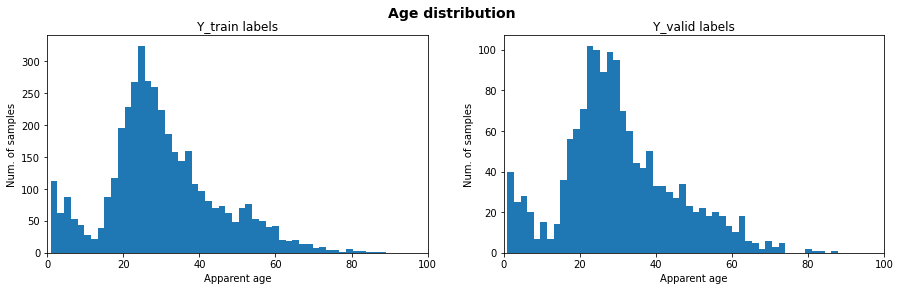

In [8]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 4))
fig.suptitle('Age distribution', fontsize=14, fontweight='bold')

# labels are multiplied by 100 to show the original values
ax1.hist(Y_train*100, bins = 50)
ax1.set_title('Y_train labels')
ax1.set(xlabel='Apparent age', ylabel='Num. of samples')
ax1.set_xlim([0, 100])

ax2.hist(Y_valid*100, bins = 50)
ax2.set_title('Y_valid labels')
ax2.set(xlabel='Apparent age', ylabel='Num. of samples')
ax2.set_xlim([0, 100])
plt.show()

### Visualizing the distributions of metadata (Train data)

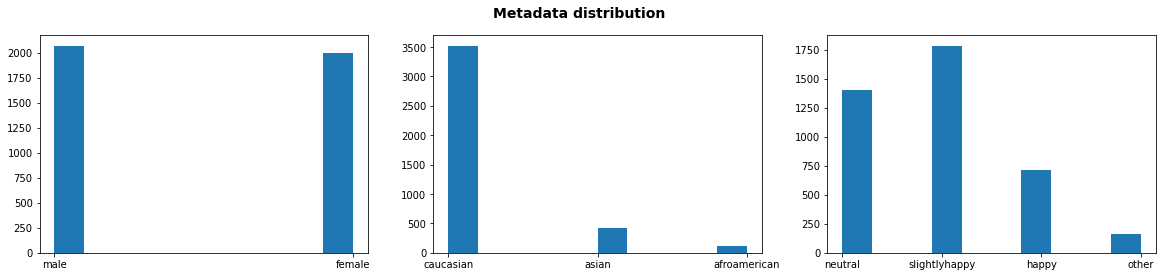

In [9]:
gender = []
etnhicity = []
emotion = []
for sample in M_train:
    gender.append(sample[0])
    etnhicity.append(sample[1])
    emotion.append(sample[2])

fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(20, 4))
fig.suptitle('Metadata distribution', fontsize=14, fontweight='bold')

ax1.hist(gender)
ax2.hist(etnhicity)
ax3.hist(emotion)
plt.show()

### Visualizing the age distribution per Ethnicity

In [10]:
def compute_hist_per_ethnicity(y_data, metadata, label):
    age_per_eth = {
        'asian': [],
        'afroamerican': [],
        'caucasian': [],
    }
    for meta, y in zip(metadata, y_data):
        age_per_eth[meta[1]].append(y)

    fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(15, 3))
    fig.suptitle(f'Age distribution per Ethnicity {label}',
                 fontsize=14, fontweight='bold')

    ax1.hist(age_per_eth['asian'], bins=50)
    ax1.set_xlim([0, 100])
    ax1.set(xlabel='Asian', ylabel='Num. of samples')

    ax2.hist(age_per_eth['afroamerican'], bins=50)
    ax2.set_xlim([0, 100])
    ax2.set(xlabel='Afroamerican', ylabel='Num. of samples')

    ax3.hist(age_per_eth['caucasian'], bins=50) 
    ax3.set_xlim([0, 100])
    ax3.set(xlabel='Caucasian', ylabel='Num. of samples')
    plt.show()

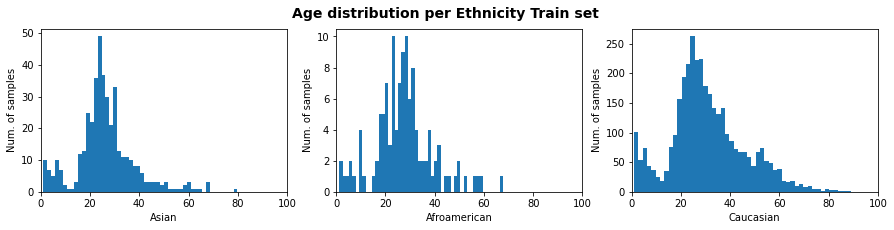

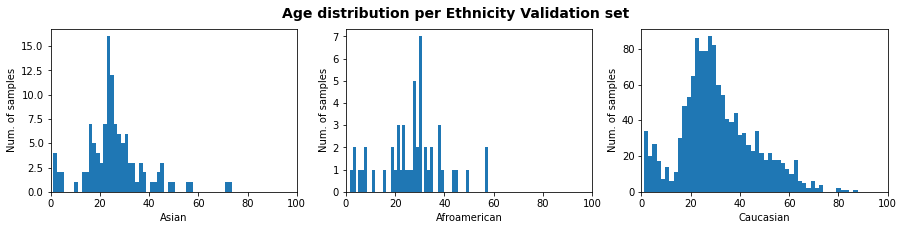

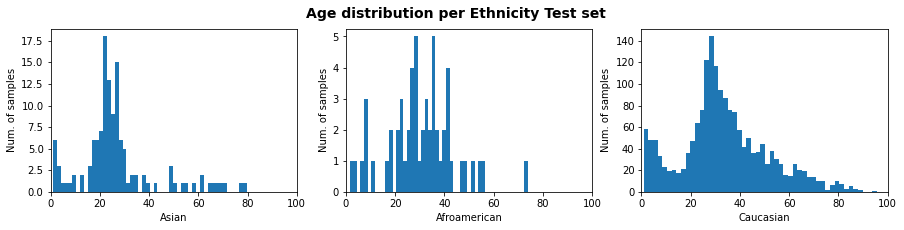

In [11]:
compute_hist_per_ethnicity(Y_train*100, M_train, 'Train set')
compute_hist_per_ethnicity(Y_valid*100, M_valid, 'Validation set')
compute_hist_per_ethnicity(Y_test, M_test, 'Test set')

---
# Bias functions definitions.
The amount of samples representing different groups in the dataset is clearly visible. In this exercise a number of methods will be used to evaluate and guide the model towards unbiased age estimation. At this stage, the main goal is not to achieve the best accuracy score but to check how various methods impact the process of training. 

Below, the functions to estimate the bias made by the model are defined. Having the metadata attached to the dataset, it is possible to compute the following:
  - Age bias
  - Gender bias
  - Ethnicity bias
  - Facial Expression bias

Given a particular attribute, we compute the MAE for different groups. For the case of age, detailed next, we will have 4 groups base on different age ranges. Then, we will have $MAE_1$, $MAE_2$, $MAE_3$ and $MAE_4$. Then, we compute the Absolute Difference among all. That is,
  - $D_{1,2} = |MAE_1-MAE_2|$
  - $D_{1,3} = |MAE_1-MAE_3|$
  - $D_{1,4} = |MAE_1-MAE_4|$
  - $D_{2,3} = |MAE_2-MAE_3|$
  - $D_{2,4} = |MAE_2-MAE_4|$
  - $D_{3,4} = |MAE_3-MAE_4|$

The final score is obtained by the average of the absolute differentes. In the case of age:
  - $B_a = (D_{1,2} + D_{1,3} + D_{1,4} + D_{2,3} + D_{2,4} + D_{3,4})/6$

## Age Bias ($B_a$)

In [12]:
def age_bias(predictions, gt):
    error_g1 = []
    error_g2 = []
    error_g3 = []
    error_g4 = []
    for i in range(len(gt)):
        if gt[i] < 20:
            error_g1.append(abs(predictions[i] - gt[i]))
        elif 20 <= gt[i] < 40:
            error_g2.append(abs(predictions[i] - gt[i]))
        elif 40 <= gt[i] < 60:
            error_g3.append(abs(predictions[i] - gt[i]))
        elif gt[i] >= 60:
            error_g4.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Age analysis:')
    print(f'Size group 1 = {len(error_g1)}, MAE = {np.mean(error_g1)}')
    print(f'Size group 2 = {len(error_g2)}, MAE = {np.mean(error_g2)}')
    print(f'Size group 3 = {len(error_g3)}, MAE = {np.mean(error_g3)}')
    print(f'Size group 4 = {len(error_g4)}, MAE = {np.mean(error_g4)}')

    age_bias = sum((
        abs(np.mean(error_g1) - np.mean(error_g2)),
        abs(np.mean(error_g1) - np.mean(error_g3)),
        abs(np.mean(error_g1) - np.mean(error_g4)),
        abs(np.mean(error_g2) - np.mean(error_g3)),
        abs(np.mean(error_g2) - np.mean(error_g4)),
        abs(np.mean(error_g3) - np.mean(error_g4)),
    )) / 6

    print('---------')
    print(f'Age bias (Ba) = {age_bias}')

## Gender Bias ($B_g$) 
Evaluates (on the test set) how accurate the model is with respect to gender.


In [13]:
def gender_bias(predictions, gt, metadata):
    error_m = []
    error_f = []
    for i in range(len(gt)):
        if metadata[i][0] == 'female':
            error_f.append(abs(predictions[i] - gt[i]))
        else:
            error_m.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Gender analysis:')
    print(f'Size group female = {len(error_f)}, MAE = {np.mean(error_f)}')
    print(f'Size group male = {len(error_m)}, MAE = {np.mean(error_m)}')

    gender_bias = abs(np.mean(error_f) - np.mean(error_m))

    print('---------')
    print(f'Gender bias (Bg) = {gender_bias}')

## Ethnicity Bias ($B_e$)
Evaluates (on the test set) how accurate the model is with respect to ethnicity category.

In [14]:
def ethnicity_bias(predictions, gt, metadata):
    error_as = []
    error_af = []
    error_ca = []
    for i in range(len(gt)):
        if metadata[i][1] == 'asian':
            error_as.append(abs(predictions[i] - gt[i]))
        elif metadata[i][1] == 'afroamerican':
            error_af.append(abs(predictions[i] - gt[i]))
        elif metadata[i][1] == 'caucasian':
            error_ca.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Ethnicity Analysis:')
    print(f'Size group asian = {len(error_as)}, MAE = {np.mean(error_as)}')
    print(f'Size group afroamerican = {len(error_af)}, MAE = {np.mean(error_af)}')
    print(f'Size group caucasian = {len(error_ca)}, MAE = {np.mean(error_ca)}')

    ethnicity_bias = sum((
        abs(np.mean(error_as)-np.mean(error_af)),
        abs(np.mean(error_as)-np.mean(error_ca)),
        abs(np.mean(error_af)-np.mean(error_ca)),
    )) / 3

    print('---------')
    print(f'Ethnicity bias (Be) = {ethnicity_bias}')

## Face expression bias ($B_f$)
Evaluates (on the test set) how accurate the model is with respect to face expression categories.

In [15]:
def face_expression_bias(predictions, gt, metadata):
    error_h = []
    error_s = []
    error_n = []
    error_o = []
    for i in range(len(gt)):
        if metadata[i][2] == 'happy':
            error_h.append(abs(predictions[i] - gt[i]))
        elif metadata[i][2] == 'slightlyhappy':
            error_s.append(abs(predictions[i] - gt[i]))
        elif metadata[i][2] == 'neutral':
            error_n.append(abs(predictions[i] - gt[i]))
        elif metadata[i][2] == 'other':
            error_o.append(abs(predictions[i] - gt[i]))

    print('=============================')
    print('Face experession Analysis:')
    print(f'Size group happy = {len(error_h)}, MAE = {np.mean(error_h)}')
    print(f'Size group slightlyhappy = {len(error_s)}, MAE = {np.mean(error_s)}')
    print(f'Size group neutral = {len(error_n)}, MAE = {np.mean(error_n)}')
    print(f'Size group other = {len(error_o)}, MAE = {np.mean(error_o)}')

    face_bias = sum((
        abs(np.mean(error_h) - np.mean(error_s)),
        abs(np.mean(error_h) - np.mean(error_n)),
        abs(np.mean(error_h) - np.mean(error_o)),
        abs(np.mean(error_s) - np.mean(error_n)),
        abs(np.mean(error_s) - np.mean(error_o)),
        abs(np.mean(error_n) - np.mean(error_o)),
    ))/6

    print('---------')
    print('Face Expression bias (Bf) = ', face_bias)

---
---
# Weighted loss strategies 

## Weight calculation

In [16]:
# Compute classes weights.
weights_gender = compute_class_weight(
    'balanced', 
    classes=np.unique(M_train[:,0]), 
    y=M_train[:,0],
)
weights_ethnicity = compute_class_weight(
    'balanced', 
    classes=np.unique(M_train[:,1]), 
    y=M_train[:,1],
)
weights_expression = compute_class_weight(
    'balanced', 
    classes=np.unique(M_train[:,2]), 
    y=M_train[:,2],
)

classes_gender = np.unique(M_train[:,0])
classes_ethnicity = np.unique(M_train[:,1])
classes_expression = np.unique(M_train[:,2])

# Compute age weights.
g1 = g2 = g3 = g4 = 0
for y in Y_train:
    age = y * 100
    if(age < 20):
        g1 +=1
    elif(20 <= age <40):
        g2 +=1
    elif(40 <= age <60):
        g3 +=1
    elif(age >= 60):
        g4 +=1
weights_age = (
    sum(np.array([g1, g2, g3, g4]))
    / (4 * np.array([g1, g2, g3, g4]))
)

In [17]:
# Linking age weights to each sample
sample_weights_age = []
age_category = []
for y in Y_train:
    age = y * 100
    if age < 20:
        sample_weights_age.append(weights_age[0])
        age_category.append('1')
    elif 20 <= age < 40:
        sample_weights_age.append(weights_age[1])
        age_category.append('2')
    elif 40 <= age < 60:
        sample_weights_age.append(weights_age[2])
        age_category.append('3')
    elif age >= 60:
        sample_weights_age.append(weights_age[3])
        age_category.append('4')
sample_weights_age = np.array(sample_weights_age)

# Combined weights: Age, gender, ethnicity, expression
M_combined = (
    np.char.array(age_category) 
    + np.char.array(M_train[:,0]) 
    + np.char.array(M_train[:,1]) 
    + np.char.array(M_train[:,2])
)

# Combined weights (Mixing categories as one)
weights_combined = compute_class_weight(
    'balanced', 
    classes=np.unique(M_combined), 
    y=M_combined,
)

classes_combined = np.unique(M_combined)

In [18]:
# Linking ethnicity weights to each sample.
sample_weights_ethnicity = []
for i in range(M_train.shape[0]):
    if M_train[i,1] == classes_ethnicity[0]:
        sample_weights_ethnicity.append(weights_ethnicity[0])
    elif M_train[i,1] == classes_ethnicity[1]:
        sample_weights_ethnicity.append(weights_ethnicity[1])
    elif M_train[i,1] == classes_ethnicity[2]:
        sample_weights_ethnicity.append(weights_ethnicity[2])
sample_weights_ethnicity = np.array(sample_weights_ethnicity)

In [19]:
# Linking expression weights to each sample.
sample_weights_expression = []
for i in range(M_train.shape[0]):
    if M_train[i,2] == classes_expression[0]:
        sample_weights_expression.append(weights_expression[0])
    elif M_train[i,2] == classes_expression[1]:
        sample_weights_expression.append(weights_expression[1])
    elif M_train[i,2] == classes_expression[2]:
        sample_weights_expression.append(weights_expression[2])
    elif M_train[i,2] == classes_expression[3]:
        sample_weights_expression.append(weights_expression[3])
sample_weights_expression = np.array(sample_weights_expression)

In [20]:
# Linking gender weights to each sample
sample_weights_gender = []
for i in range(M_train.shape[0]):
    if M_train[i,0] == classes_gender[0]:
        sample_weights_gender.append(weights_expression[0])
    elif M_train[i,0] == classes_gender[1]:
        sample_weights_gender.append(weights_expression[1])
sample_weights_gender = np.array(sample_weights_gender)

In [21]:
# Linking combined weights to each sample
sample_weights_combined = []
for i in range(M_train.shape[0]):
    for category in range(classes_combined.shape[0]):
        if M_combined[i] == classes_combined[category]:
            sample_weights_combined.append(weights_combined[category])

In [22]:
def random_noise_weights_function(weights):
    weights_noise = np.random.randn(sample_weights.shape[0]) * 0.05
    return  sample_weights + weights_noise

# Custom weighted samples
Below, the weights computed previously are used to create various combinations to generate weights for the corresponding samples.

In [23]:
# Strategy 1: Age+Ethnicity+Facial Expression.
sample_weights = (
    sample_weights_age + sample_weights_ethnicity + sample_weights_expression
) / 3.
# Strategy 2: Age+Ethnicity.
sample_weights = (
    sample_weights_age + sample_weights_ethnicity 
) / 2.
# Strategy 3: Age+Ethnicity+Facial Expression+Gender
sample_weights = (
    sample_weights_age + sample_weights_ethnicity 
    + sample_weights_expression + sample_weights_gender
) / 4.
# Strategy 4: Weighted average Age+Ethnicity+Facial Expression 631
sample_weights = (
    0.6*sample_weights_age + 0.3*sample_weights_ethnicity 
    + 0.1*sample_weights_expression
)
# Strategy 5: Weighted average Age+Ethnicity+Facial Expression 532
sample_weights = (
    0.5*sample_weights_age + 0.3*sample_weights_ethnicity + 
    0.2*sample_weights_expression
)
# Strategy 6: Combined weights Age+Gender+Ethnicity+Facial Expression
sample_weights = np.array(sample_weights_combined)
# Strategy 7: Noised Weighted average Age+Ethnicity+Expression
sample_weights = random_noise_weights_function(
    0.6*sample_weights_age + 0.3*sample_weights_ethnicity 
    + 0.1*sample_weights_expression
)

In [24]:
saved_model = load_model(root_dir / 'model_checkpoint_2.h5')
saved_model.trainable = True

es = EarlyStopping(
    monitor='val_mae', 
    mode='min', 
    verbose=1, 
    patience=10,
)
mc = ModelCheckpoint(
    'weighted_model_checkpoint.h5',
    monitor='val_mae',
    mode='min',
    save_best_only=True,
)
rp = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

saved_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-4),
    loss=tf.keras.losses.MeanSquaredError(),
    metrics=['mae'],
)

history = saved_model.fit(
    X_train, Y_train, 
    sample_weight=sample_weights, 
    validation_data=(X_valid, Y_valid), 
    batch_size=16, 
    epochs=10, 
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp],
)

with open('train_history_weighted.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
255/255 [==============================] - 69s 192ms/step - loss: 0.2092 - mae: 0.1128 - val_loss: 0.2376 - val_mae: 0.1923 - lr: 1.0000e-04
Epoch 2/10
255/255 [==============================] - 46s 180ms/step - loss: 0.2133 - mae: 0.1224 - val_loss: 0.2888 - val_mae: 0.2942 - lr: 1.0000e-04
Epoch 3/10
255/255 [==============================] - 48s 188ms/step - loss: 0.2160 - mae: 0.1278 - val_loss: 0.2196 - val_mae: 0.1580 - lr: 1.0000e-04
Epoch 4/10
255/255 [==============================] - 48s 187ms/step - loss: 0.2117 - mae: 0.1195 - val_loss: 0.2279 - val_mae: 0.1866 - lr: 1.0000e-04
Epoch 5/10
255/255 [==============================] - 47s 185ms/step - loss: 0.2026 - mae: 0.1170 - val_loss: 0.2286 - val_mae: 0.1877 - lr: 1.0000e-04
Epoch 6/10
255/255 [==============================] - 48s 187ms/step - loss: 0.1945 - mae: 0.1127 - val_loss: 0.2269 - val_mae: 0.2032 - lr: 1.0000e-04
Epoch 7/10
255/255 [==============================] - 49s 191ms/step - loss: 0.1927 - ma

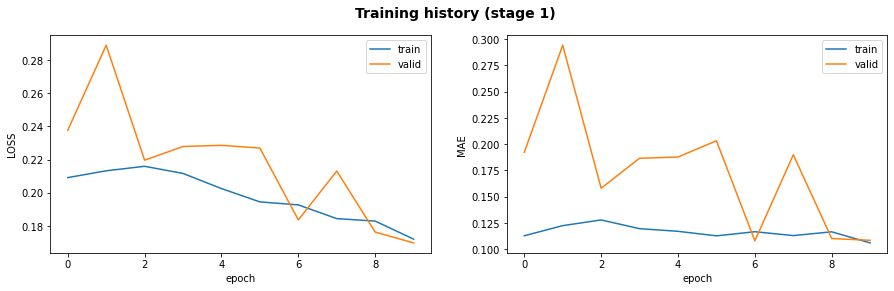

In [25]:
train_hist = pickle.load(open("train_history_weighted.pkl","rb"))
plot_train_history(train_hist)

In [28]:
# Evaluate the model.
saved_model = load_model('weighted_model_checkpoint.h5')
model_predictions = evaluate_model(saved_model)
age_bias(model_predictions, Y_test)
gender_bias(model_predictions, Y_test, M_test)
ethnicity_bias(model_predictions, Y_test, M_test)
face_expression_bias(model_predictions, Y_test, M_test)

62/62 [==============================] - 6s 84ms/step
MAE = 12.48674245
Age analysis:
Size group 1 = 369, MAE = 16.801435470581055
Size group 2 = 1044, MAE = 9.229103088378906
Size group 3 = 390, MAE = 11.433262825012207
Size group 4 = 175, MAE = 25.17080307006836
---------
Age bias (Ba) = 8.865545431772867
Gender analysis:
Size group female = 1020, MAE = 12.542098999023438
Size group male = 958, MAE = 12.427803993225098
---------
Gender bias (Bg) = 0.11429500579833984
Ethnicity Analysis:
Size group asian = 129, MAE = 13.122503280639648
Size group afroamerican = 56, MAE = 10.618128776550293
Size group caucasian = 1793, MAE = 12.499363899230957
---------
Ethnicity bias (Be) = 1.669583002726237
Face experession Analysis:
Size group happy = 589, MAE = 13.209915161132812
Size group slightlyhappy = 505, MAE = 12.009199142456055
Size group neutral = 756, MAE = 12.133197784423828
Size group other = 128, MAE = 13.131203651428223
---------
Face Expression bias (Bf) =  0.766692320505778


# Custom Loss Function : Age Bias
Another strategy applied is to include age bias term in the loss function. Age bias was selected because it's the fastest to implement given no dependency of metadata. 

In [29]:
def age_bias_loss(predictions, gt):
    """Custom loss function to compute age bias."""

    def zero_or_mean(prediction_masked, gt_masked):
        # Prevent returning NaN when tensors are empty.
        return tf.cond(
            tf.equal(tf.size(gt_masked), 0),
            lambda : tf.constant(0.0),
            lambda: tf.reduce_mean(prediction_masked - gt_masked),
        )

    def filter_values(mask_1, mask_2=None):
        # Apply filtering masks to tensors with data.
        if mask_2 is None:
            mask = mask_1
        else:
            mask = tf.logical_and(mask_1, mask_2)
        return tf.boolean_mask(predictions, mask), tf.boolean_mask(gt, mask)


    # MEA for age<20
    prediction_mask, gt_mask = filter_values(gt < 20)
    error_g1_mean = zero_or_mean(prediction_mask, gt_mask)

    # MEA for 20 <= age < 40
    prediction_mask, gt_mask = filter_values(20 <= gt, gt < 40)
    error_g2_mean = zero_or_mean(prediction_mask, gt_mask)

    # MEA for 40 <= age < 60
    prediction_mask, gt_mask = filter_values(40 <= gt, gt < 60)
    error_g3_mean = zero_or_mean(prediction_mask, gt_mask)

    # MEA for 60 <= age
    prediction_mask, gt_mask = filter_values(60 <= gt)
    error_g4_mean = zero_or_mean(prediction_mask, gt_mask)

    fn = tf.square
    age_bias = (
      fn(error_g1_mean - error_g2_mean) +
      fn(error_g1_mean - error_g3_mean) +
      fn(error_g1_mean - error_g4_mean) +
      fn(error_g2_mean - error_g3_mean) +
      fn(error_g2_mean - error_g4_mean) +
      fn(error_g3_mean - error_g4_mean)
    )

    return age_bias / 6

In [30]:
saved_model = load_model(root_dir / 'model_checkpoint_2.h5')
saved_model.trainable = True

mse_loss = tf.keras.losses.MeanSquaredError()

def custom_loss(predictions, gt):
    return (
        6 * age_bias_loss(predictions, gt) 
        + mse_loss(predictions, gt)
    )

es = EarlyStopping(
    monitor='val_loss',
    mode='min', 
    verbose=1, 
    patience=5,
)
mc = ModelCheckpoint(
    'custom_loss_model_checkpoint.h5', 
    monitor='val_loss', 
    save_best_only=True,
)
rp = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.5,
    patience=5,
    min_lr=1e-5,
    verbose=1,
)

saved_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=custom_loss,
    metrics=['mae'],
)
history = saved_model.fit(
    X_train, 
    Y_train, 
    validation_data=(X_valid, Y_valid), 
    batch_size=16, 
    epochs=10, 
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp],
)

with open('custom_loss_model_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
255/255 [==============================] - 57s 192ms/step - loss: 0.1978 - mae: 0.0936 - val_loss: 0.1933 - val_mae: 0.0848 - lr: 1.0000e-05
Epoch 2/10
255/255 [==============================] - 49s 190ms/step - loss: 0.1933 - mae: 0.0816 - val_loss: 0.1911 - val_mae: 0.0805 - lr: 1.0000e-05
Epoch 3/10
255/255 [==============================] - 48s 190ms/step - loss: 0.1902 - mae: 0.0730 - val_loss: 0.1903 - val_mae: 0.0791 - lr: 1.0000e-05
Epoch 4/10
255/255 [==============================] - 49s 192ms/step - loss: 0.1877 - mae: 0.0676 - val_loss: 0.1887 - val_mae: 0.0769 - lr: 1.0000e-05
Epoch 5/10
255/255 [==============================] - 49s 193ms/step - loss: 0.1858 - mae: 0.0636 - val_loss: 0.1878 - val_mae: 0.0747 - lr: 1.0000e-05
Epoch 6/10
255/255 [==============================] - 49s 193ms/step - loss: 0.1839 - mae: 0.0609 - val_loss: 0.1870 - val_mae: 0.0743 - lr: 1.0000e-05
Epoch 7/10
255/255 [==============================] - 49s 193ms/step - loss: 0.1832 - ma

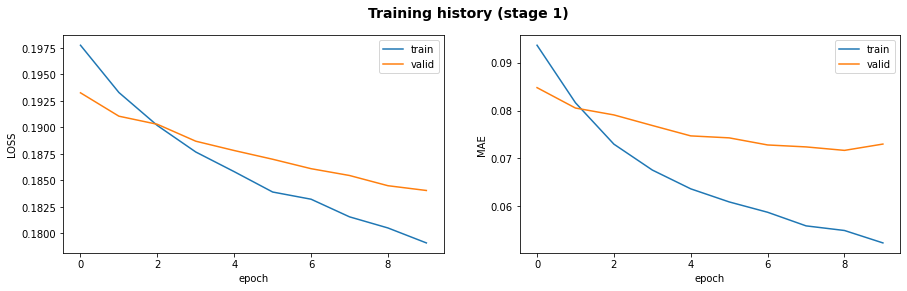

In [31]:
train_hist = pickle.load(open("custom_loss_model_history.pkl","rb"))
plot_train_history(train_hist)

In [33]:
# Evaluate the model.
saved_model = load_model(
    'custom_loss_model_checkpoint.h5',
    custom_objects={'custom_loss': custom_loss},
)
model_predictions = evaluate_model(saved_model)
age_bias(model_predictions, Y_test)
gender_bias(model_predictions, Y_test, M_test)
ethnicity_bias(model_predictions, Y_test, M_test)
face_expression_bias(model_predictions, Y_test, M_test)

62/62 [==============================] - 5s 79ms/step
MAE = 7.85855893
Age analysis:
Size group 1 = 369, MAE = 9.013604164123535
Size group 2 = 1044, MAE = 6.241055488586426
Size group 3 = 390, MAE = 9.313507080078125
Size group 4 = 175, MAE = 11.830170631408691
---------
Age bias (Ba) = 2.844541390736898
Gender analysis:
Size group female = 1020, MAE = 7.992023468017578
Size group male = 958, MAE = 7.716457366943359
---------
Gender bias (Bg) = 0.27556610107421875
Ethnicity Analysis:
Size group asian = 129, MAE = 6.903904438018799
Size group afroamerican = 56, MAE = 7.33374547958374
Size group caucasian = 1793, MAE = 7.943634033203125
---------
Ethnicity bias (Be) = 0.6931530634562174
Face experession Analysis:
Size group happy = 589, MAE = 8.102019309997559
Size group slightlyhappy = 505, MAE = 8.177955627441406
Size group neutral = 756, MAE = 7.416502475738525
Size group other = 128, MAE = 8.089035987854004
---------
Face Expression bias (Bf) =  0.3828904628753662


# Custom Loss with Weighted Samples
Combining custom loss function with the best weighted samples strategy. 

In [35]:
saved_model = load_model(root_dir / 'model_checkpoint_2.h5')
saved_model.trainable = True

mse_loss = tf.keras.losses.MeanSquaredError()
def custom_loss(predictions, gt):
    return 0.5*age_bias_loss(predictions, gt) + 0.5*mse_loss(predictions, gt)

sample_weights = (
    0.6*sample_weights_age + 0.3*sample_weights_ethnicity 
    + 0.1*sample_weights_expression
)

es = EarlyStopping(
    monitor='val_loss',
    mode='min', 
    verbose=1, 
    patience=5,
)
mc = ModelCheckpoint(
    'custom_loss_weighted_model_checkpoint.h5', 
    monitor='val_loss', 
    save_best_only=True,
)
rp = ReduceLROnPlateau(
    monitor='val_mae',
    factor=0.1,
    patience=3,
    min_lr=1e-5,
    verbose=1
)

saved_model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-5),
    loss=custom_loss,
    metrics=['mae'],
)

history = saved_model.fit(
    X_train, 
    Y_train,
    sample_weight=sample_weights,
    validation_data=(X_valid, Y_valid),
    batch_size=16, 
    epochs=10, 
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp],
)

# saving training history
with open('custom_loss_weighted_model_history.pkl', 'wb') as handle:
    pickle.dump(history.history, handle, protocol=pickle.HIGHEST_PROTOCOL)

Epoch 1/10
255/255 [==============================] - 60s 207ms/step - loss: 0.1858 - mae: 0.0929 - val_loss: 0.1830 - val_mae: 0.0793 - lr: 1.0000e-05
Epoch 2/10
255/255 [==============================] - 49s 194ms/step - loss: 0.1817 - mae: 0.0758 - val_loss: 0.1813 - val_mae: 0.0785 - lr: 1.0000e-05
Epoch 3/10
255/255 [==============================] - 49s 194ms/step - loss: 0.1788 - mae: 0.0672 - val_loss: 0.1797 - val_mae: 0.0778 - lr: 1.0000e-05
Epoch 4/10
255/255 [==============================] - 49s 194ms/step - loss: 0.1766 - mae: 0.0630 - val_loss: 0.1774 - val_mae: 0.0758 - lr: 1.0000e-05
Epoch 5/10
255/255 [==============================] - 50s 197ms/step - loss: 0.1745 - mae: 0.0602 - val_loss: 0.1754 - val_mae: 0.0746 - lr: 1.0000e-05
Epoch 6/10
255/255 [==============================] - 49s 193ms/step - loss: 0.1722 - mae: 0.0573 - val_loss: 0.1732 - val_mae: 0.0728 - lr: 1.0000e-05
Epoch 7/10
255/255 [==============================] - 49s 194ms/step - loss: 0.1700 - ma

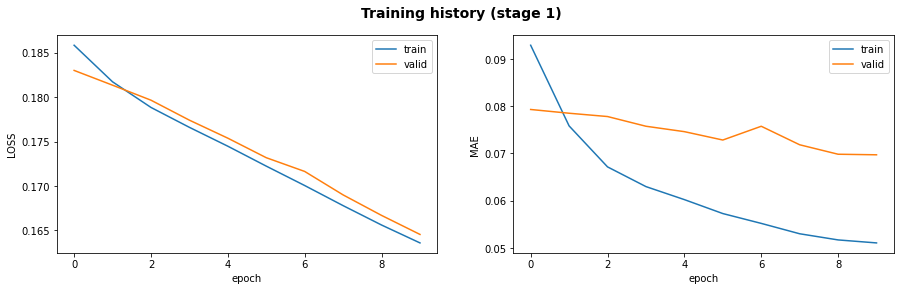

In [36]:
train_hist = pickle.load(open("custom_loss_weighted_model_history.pkl","rb"))
plot_train_history(train_hist)

In [38]:
# Evaluate the model.
saved_model = load_model(
    'custom_loss_weighted_model_checkpoint.h5',
    custom_objects={'custom_loss': custom_loss},
)
model_predictions = evaluate_model(saved_model)
age_bias(model_predictions, Y_test)
gender_bias(model_predictions, Y_test, M_test)
ethnicity_bias(model_predictions, Y_test, M_test)
face_expression_bias(model_predictions, Y_test, M_test)

62/62 [==============================] - 5s 76ms/step
MAE = 7.70134674
Age analysis:
Size group 1 = 369, MAE = 7.7959303855896
Size group 2 = 1044, MAE = 6.266838073730469
Size group 3 = 390, MAE = 9.540582656860352
Size group 4 = 175, MAE = 11.960912704467773
---------
Age bias (Ba) = 3.137812693913778
Gender analysis:
Size group female = 1020, MAE = 7.89451789855957
Size group male = 958, MAE = 7.495673656463623
---------
Gender bias (Bg) = 0.39884424209594727
Ethnicity Analysis:
Size group asian = 129, MAE = 7.029192924499512
Size group afroamerican = 56, MAE = 7.243156909942627
Size group caucasian = 1793, MAE = 7.764016151428223
---------
Ethnicity bias (Be) = 0.4898821512858073
Face experession Analysis:
Size group happy = 589, MAE = 8.009069442749023
Size group slightlyhappy = 505, MAE = 7.797771453857422
Size group neutral = 756, MAE = 7.423113822937012
Size group other = 128, MAE = 7.5482330322265625
---------
Face Expression bias (Bf) =  0.3345675468444824


# Multiple output model
The idea behind this implementation is that we can generate additional outputs to improve the model training. Instead of returning a single number representing an age, model had additional outputs that judge about "age category" defined as its range. It is possible to generate age categories with various granularity or even use a couple of them for the training.

## Model definition

In [ ]:
# downloading the data
if not pathlib.Path(root_dir / 'model.zip').exists():
    !wget https://data.chalearnlap.cvc.uab.cat/Colab_2021/model.zip

# decompressing the data
with zipfile.ZipFile(root_dir / 'model.zip','r') as zip_file:
    zip_file.extractall()
    print('Model decompressed successfully')

model = tf.keras.models.load_model('./model/weights.h5')

In [ ]:
flatten = model.get_layer('flatten_1').output #2048

# Dense layer + Batch Normalization + Dropout
fc_200 = Dense(200, activation='relu', name='f_200')(flatten)
batch_norm = BatchNormalization()(fc_200)
dp_layer = Dropout(0.4)(batch_norm)

# Dense layer + Dropout
fc_30 = Dense(30, activation='relu', name='f_30')(dp_layer)
dp_layer_2 = Dropout(0.4)(fc_30)

# Regression output layes
output_reg = Dense(1, activation='sigmoid', name='predict_reg')(fc_30)
output_class = Dense(4, activation='softmax', name='predict_class')(fc_30)

model = Model(
    inputs=model.get_layer('base_input').output, 
    outputs=[output_reg, output_class],
)
print(model.summary())

In [ ]:
def Y_to_categorical_100(Y):
    y_categorical = np.zeros((Y.shape[0], 100))
    for k in range(len(Y)):
        y_categorical[k, int(Y[k]*100)] =1
    return y_categorical 

In [ ]:
def Y_to_categorical_4(Y):
    y_categorical = np.zeros((Y.shape[0], 4))
    for i in range(len(Y)):
        age = Y[i]*100
        if age < 20:
            y_categorical[i, 0] =1
        elif 20 <= age < 40:
            y_categorical[i, 1] =1
        elif 40 <= age < 60:
            y_categorical[i, 2] =1
        elif age >= 60:
            y_categorical[i, 3] =1
    return y_categorical 

In [ ]:
for counter, layer in enumerate(model.layers):
    layer.trainable = (counter > 174)

es = EarlyStopping(
    monitor='val_loss', 
    verbose=1, 
    patience=5,
)
mc = ModelCheckpoint(
    'multi_output_model_checkpoint.h5', 
    monitor='val_loss',
    save_best_only=True,
)
rp = ReduceLROnPlateau(
    factor=0.1,
    patience=3,
    min_lr=0.00001,
    verbose=1,
)

model.compile(
    tf.keras.optimizers.Adam(learning_rate=1e-3),
    loss=[
        tf.keras.losses.MeanSquaredError(), 
        tf.keras.losses.CategoricalCrossentropy(),
    ],
    metrics=['mae']
)

history = model.fit(
    X_train, 
    [Y_train, Y_to_categorical_4(Y_train)], 
    validation_data=(
        X_valid,
        [Y_valid, Y_to_categorical_4(Y_valid)],
    ),
    batch_size=64, 
    epochs=30,
    shuffle=True, 
    verbose=1, 
    callbacks=[es, mc, rp]
)

In [ ]:
# Evaluate the model.
saved_model = load_model('multi_output_model_checkpoint.h5')
model_predictions = evaluate_model(saved_model)
age_bias(model_predictions, Y_test)
gender_bias(model_predictions, Y_test, M_test)
ethnicity_bias(model_predictions, Y_test, M_test)
face_expression_bias(model_predictions, Y_test, M_test)